# Kaggle Titanic Competition

In [55]:
%matplotlib inline

from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 6

train_df = pd.read_csv('train.csv')

## Some general information
### Structure of df
    PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked
    survival        Survival
                    (0 = No; 1 = Yes)
    pclass          Passenger Class
                    (1 = 1st; 2 = 2nd; 3 = 3rd)
    name            Name
    sex             Sex
    age             Age
    sibsp           Number of Siblings/Spouses Aboard
    parch           Number of Parents/Children Aboard
    ticket          Ticket Number
    fare            Passenger Fare
    cabin           Cabin
    embarked        Port of Embarkation
                    (C = Cherbourg; Q = Queenstown; S = Southampton)
** Likely to have little to do with final model: **
- ticket
- fare
- name

In [44]:
print train_df.Cabin.count()


204


Looks like Cabin is pretty empty, so update df

In [45]:
df = train_df
df = df.drop(['Ticket', 'Fare', 'Name', 'Cabin'], axis=1)
df = df.dropna()
df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,1,0,3,male,22,1,0,S
1,2,1,1,female,38,1,0,C
2,3,1,3,female,26,0,0,S
3,4,1,1,female,35,1,0,S
4,5,0,3,male,35,0,0,S
6,7,0,1,male,54,0,0,S
7,8,0,3,male,2,3,1,S
8,9,1,3,female,27,0,2,S
9,10,1,2,female,14,1,0,C
10,11,1,3,female,4,1,1,S


In [46]:
#simple function to help calculate simple probabilities
def simpleProbability(train_df, name, val):
    total = len(train_df[train_df[name] == val])
    d = (train_df[name] == val) & (train_df['Survived'] == 1)
    t_pclass = len(d[d == True])
    print('rate ' + name + ' ' + str(val) + '\t' + str(t_pclass/total))

** Affect on survival rate by class:**

In [47]:
simpleProbability(df, 'Pclass', 1)
simpleProbability(df, 'Pclass', 2)
simpleProbability(df, 'Pclass', 3)


rate Pclass 1	0.652173913043
rate Pclass 2	0.479768786127
rate Pclass 3	0.239436619718


** Affect on survival rate by sex: **

In [48]:
simpleProbability(df, 'Sex', 'male')
simpleProbability(df, 'Sex', 'female')


rate Sex male	0.205298013245
rate Sex female	0.752895752896


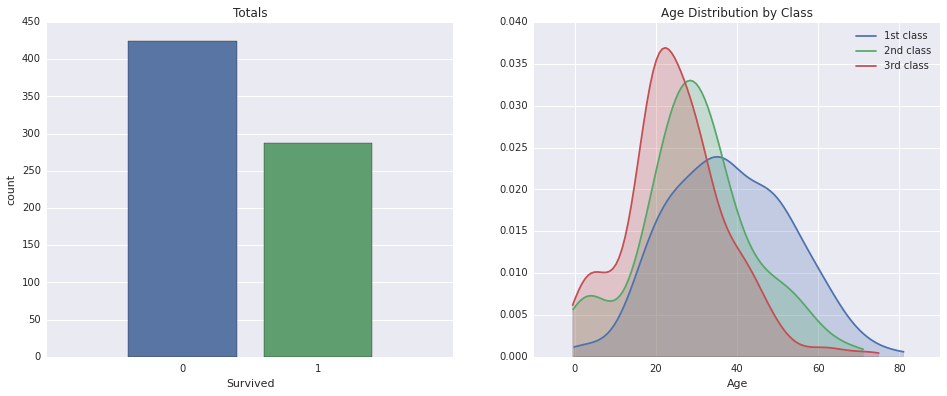

In [49]:
plt.subplot(121)
plt.title('Totals')
plotdf = pd.Series([len(df[df.Survived == 1]), len(df[df.Survived == 0])])
bar = sns.countplot(data=df, x="Survived")
bar.axes.set_xlim(-1,2)
plt.subplot(122)
plt.title('Age Distribution by Class')
plt.xlabel('Age')
sns.kdeplot(df[df.Pclass == 1].Age, shade=True, label='1st class')
sns.kdeplot(df[df.Pclass == 2].Age, shade=True, label='2nd class')
sns.kdeplot(df[df.Pclass == 3].Age, shade=True, label='3rd class')

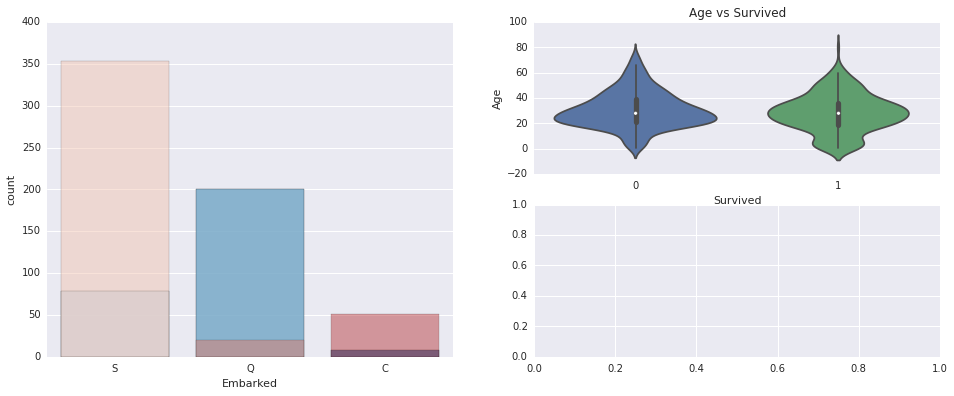

In [56]:
plt.subplot2grid((2,2), (0,0), rowspan=2)
sns.set(style="darkgrid")
sns.countplot(df.Embarked[df.Survived == 1], palette="Blues", alpha=0.85)
sns.countplot(df.Embarked[df.Survived == 0], palette="Reds", alpha=0.45)
plt.subplot2grid((2,2),(0,1))
plt.title('Age vs Survived')
sns.violinplot(y=df.Age, x=df.Survived)
plt.subplot2grid((2,2),(1,1))